### Imports

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
from scipy.special import erf
import scipy.stats

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.core.modeling_framework import MultiCompartmentSphericalMeanModel
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

from scipy.io import savemat

### Simulate Signal

In [216]:
def sim_sig_np(bf,be,tm,adc,sigma,axr,nvox):
    
    be_tiled = np.tile(be,(nvox,1))
    bf_tiled = np.tile(bf,(nvox,1))
    tm_tiled = np.tile(tm,(nvox,1))

    adc_tiled = np.transpose(np.tile(adc,(np.size(tm),1)))
    sigma_tiled = np.transpose(np.tile(sigma,(np.size(tm),1)))
    axr_tiled = np.transpose(np.tile(axr,(np.size(tm),1)))

    tm_tiled[(tm_tiled == np.min(tm_tiled)) & (bf_tiled == 0)] = np.inf

    adc_prime_tiled = adc_tiled * (1 - sigma_tiled* np.exp(-tm_tiled*axr_tiled))
    normalised_signal_tiled = np.exp(-adc_prime_tiled * be_tiled)
    
    return normalised_signal_tiled, adc_prime_tiled

def sim_sig_np_1_vox(bf,be,tm,adc,sigma,axr):

    adc_tiled = np.transpose(np.tile(adc,(np.size(tm),1)))
    sigma_tiled = np.transpose(np.tile(sigma,(np.size(tm),1)))
    axr_tiled = np.transpose(np.tile(axr,(np.size(tm),1)))

    tm[(tm == np.min(tm)) & (bf == 0)] = np.inf

    adc_prime = adc_tiled * (1 - sigma_tiled* np.exp(-tm*axr_tiled))
    normalised_signal = np.exp(-adc_prime * be)
    
    return normalised_signal, adc_prime


In [217]:
def sim_sig_pytorch(bf, be, tm, adc_tiled, sigma_tiled, axr_tiled, batch_size):
    """batch_size and nvox are kind of interchangable
    might be useful to know for testing purposes
    """
    be_tiled = torch.tile(be,(batch_size,1))
    bf_tiled = torch.tile(bf,(batch_size,1))
    tm_tiled = torch.tile(tm,(batch_size,1))

    """
    use this section for testing if function works as intended    
    adc_tiled = torch.tile(adc,(tm.shape[0],1)).t()
    sigma_tiled = torch.tile(sigma,(tm.shape[0],1)).t()
    axr_tiled = torch.tile(axr,(tm.shape[0],1)).t()
    """

    tm_tiled[(tm_tiled == torch.min(tm_tiled)) & (bf_tiled == 0)] = float('inf')
    

    adc_prime_tiled = adc_tiled * (1 - sigma_tiled * torch.exp(-tm_tiled * axr_tiled))
    normalised_signal_tiled = torch.exp(-adc_prime_tiled * be_tiled)

    return normalised_signal_tiled, adc_prime_tiled

### Initial variables.

In [226]:
nvox = 1000 # number of voxels to simulate

bf = np.array([0, 0, 250, 250, 250, 250, 250, 250]) * 1e-3   # filter b-values [ms/um2]
be = np.array([0, 250, 0, 250, 0, 250, 0, 250]) * 1e-3       # encoding b-values [ms/um2]
tm = np.array([20, 20, 20, 20, 200, 200, 400, 400], dtype=np.float32) * 1e-3 # mixing time [s]

adc_lb = 0.1        #[um2/ms]
adc_ub = 3.5        #[um2/ms]
sig_lb = 0          #[a.u.]
sig_ub = 1          #[a.u.]
axr_lb = 0.1        #[s-1]
axr_ub = 20         #[s-1]

#consider doing in si units

limits = np.array([[adc_lb, adc_ub], [sig_lb, sig_ub] , [axr_lb, axr_ub]])

adc_init = (adc_lb + adc_ub) / 2 #[um2/ms]
sig_init = (sig_lb + sig_ub) / 2 #[a.u.]
axr_init = (axr_lb + axr_ub) / 2 #[ms-1]

num_inits = 4

# Create equally spaced arrays for each parameter
# Is it logical that the variable are all low/high at the same time. 
adc_inits = np.linspace(adc_lb, adc_ub, num_inits)
sig_inits = np.linspace(sig_lb, sig_ub, num_inits)
axr_inits = np.linspace(axr_lb, axr_ub, num_inits)

# Combine the arrays into a single array with the same shape as init
all_inits = np.row_stack((adc_init, sig_init, axr_init))

sim_adc = np.random.uniform(adc_lb,adc_ub,nvox)                 # ADC, simulated [um2/ms]
sim_sigma = np.random.uniform(sig_lb,sig_ub,nvox)               # sigma, simulated [a.u.]
sim_axr = np.random.uniform(axr_lb,axr_ub,nvox)                 # AXR, simulated [ms-1]

sim_E_vox, sim_adc_prime = sim_sig_np(bf,be,tm,sim_adc,sim_sigma,sim_axr,nvox)

In [219]:
"""sim_adc1 = torch.tensor(sim_adc)
sim_sigma1 = torch.tensor(sim_sigma)
sim_axr1 = torch.tensor(sim_axr)
be = torch.tensor(be)
bf = torch.tensor(bf)
tm = torch.tensor(tm)

sim_E_vox1, sim_adc_prime1 = sim_sig_pytorch(bf,be,tm,sim_adc1,sim_sigma1,sim_axr1,nvox)"""

'sim_adc1 = torch.tensor(sim_adc)\nsim_sigma1 = torch.tensor(sim_sigma)\nsim_axr1 = torch.tensor(sim_axr)\nbe = torch.tensor(be)\nbf = torch.tensor(bf)\ntm = torch.tensor(tm)\n\nsim_E_vox1, sim_adc_prime1 = sim_sig_pytorch(bf,be,tm,sim_adc1,sim_sigma1,sim_axr1,nvox)'

### Histogram plots

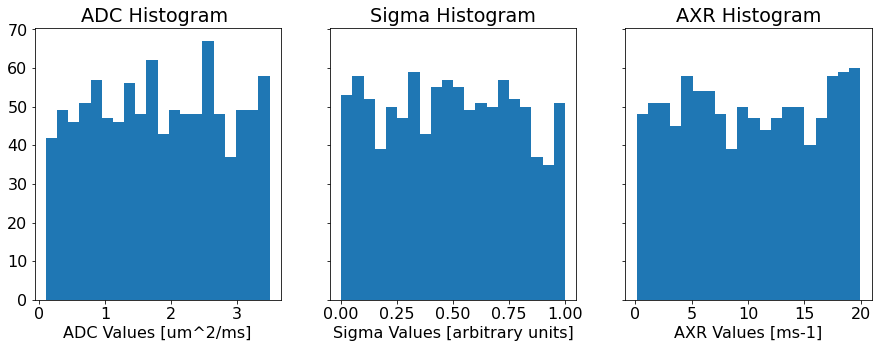

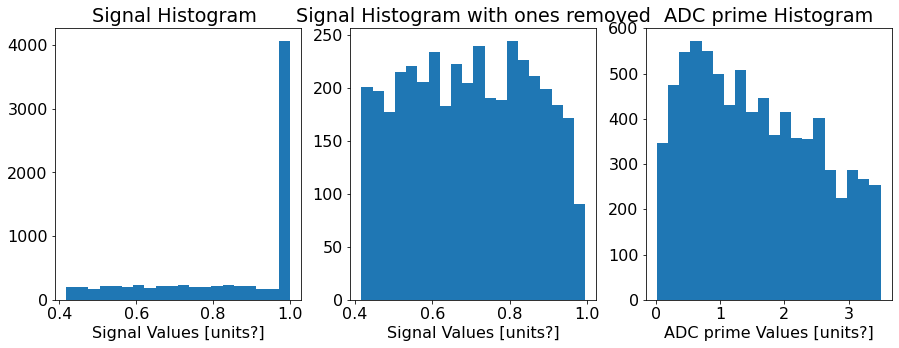

In [220]:
n_bins=20
#make 200 and voxels 100,000 to see adc prime dropoff
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(15, 5))
axs[0].hist(sim_adc, bins=n_bins)
axs[1].hist(sim_sigma, bins=n_bins)
axs[2].hist(sim_axr, bins=n_bins)
axs[0].set_title('ADC Histogram ')
axs[0].set_xlabel('ADC Values [um^2/ms]')
axs[1].set_title('Sigma Histogram')
axs[1].set_xlabel('Sigma Values [arbitrary units]')
axs[2].set_title('AXR Histogram')
axs[2].set_xlabel('AXR Values [ms-1]');


fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].hist(sim_E_vox.flatten(), bins=n_bins)
axs[0].set_title('Signal Histogram ')
axs[0].set_xlabel('Signal Values [units?]')
axs[1].hist(sim_E_vox[sim_E_vox != 1].flatten(), bins=n_bins)
axs[1].set_title('Signal Histogram with ones removed')
axs[1].set_xlabel('Signal Values [units?]')
axs[2].hist(sim_adc_prime.flatten(), bins=n_bins)
axs[2].set_title('ADC prime Histogram')
axs[2].set_xlabel('ADC prime Values [units?]');


### Plotting b-value against normalised signal

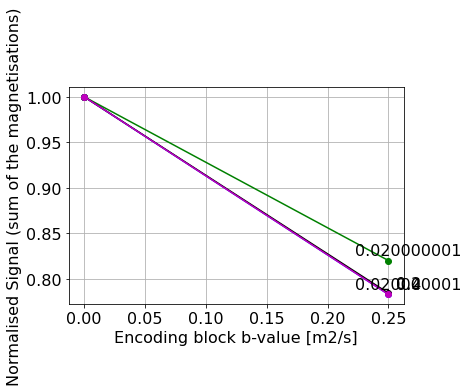

In [221]:
plt.plot([be[0], be[1]], [sim_E_vox[0,0], sim_E_vox[0,1]], 'bo-')
plt.annotate(tm[0], (be[1], sim_E_vox[0, 1]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[2], be[3]], [sim_E_vox[0,2], sim_E_vox[0,3]], 'go-')
plt.annotate(tm[2], (be[3], sim_E_vox[0, 3]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[4], be[5]], [sim_E_vox[0,4], sim_E_vox[0,5]], 'ko-')
plt.annotate(tm[4], (be[5], sim_E_vox[0, 5]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[6], be[7]], [sim_E_vox[0,6], sim_E_vox[0,7]], 'mo-')
plt.annotate(tm[6], (be[7], sim_E_vox[0, 7]), textcoords="offset points", xytext=(20,5), ha='center')


#plt.title('Scatter plot with 4 lines')
plt.xlabel('Encoding block b-value [m2/s]')
#are units correct
plt.ylabel('Normalised Signal (sum of the magnetisations)')
#unit?
plt.grid(True)
plt.show()


### Least squares fit


In [222]:
def sse_adc_prime_1_vox(variables_to_optimize, tm, bf, be, smeas):
    # For the signal from 1 voxel.
    adc_est, sigma_est, axr_est = variables_to_optimize
    _ , adc_tm_fit = sim_sig_np_1_vox(bf,be,tm,adc_est,sigma_est,axr_est)

    bf_tm = np.column_stack((bf.flatten(), tm.flatten()))

    # Find unique rows and corresponding indices
    univols, univols_indices = np.unique(bf_tm, axis=0, return_index=True)

    nsf = univols.shape[0]

    ix1 = np.where((np.sum(univols[:, None, :] == bf_tm, axis=2) == 2) & (be == 0))[1]
    ix2 = np.where((np.sum(univols[:, None, :] == bf_tm, axis=2) == 2) & (be > 0))[1]
    
    #this line is hardcoded
    smeas = smeas.reshape(8)

    adc_tm_calc = -1 / (be[ix2] - be[ix1]) * np.log(smeas[ix2] / smeas[ix1])

    #this line is hardcoded
    adc_tm_fit = adc_tm_fit[:, ::2]

    sse = np.sum((adc_tm_calc - adc_tm_fit) ** 2)
    return sse


In [223]:
def callback(xk):
    print('Estimates of ADC, sigma, AXR:    ', xk)

# Define the bounds for adc, sigma, axr
bounds = tuple(map(tuple, limits.tolist())) #this line seems messy

NLLS_adc_all = np.empty(shape=(0,))
NLLS_sigma_all = np.empty(shape=(0,))
NLLS_axr_all = np.empty(shape=(0,))
    
NLLS_adc_prime_all = np.empty(shape=(nvox,8))
NLLS_E_vox_all = np.empty(shape= (nvox,8))

sses = np.array([])
for current_vox in range(nvox):

    #extract relevant info for current voxel
    cur_E_vox = sim_E_vox[current_vox,:]
    cur_adc_prime = sim_adc_prime[current_vox,:]

    cur_adc = sim_adc[current_vox]
    cur_sigma = sim_sigma[current_vox]
    cur_axr = sim_axr[current_vox]
    
    additional_args_1_vox = (tm, bf, be, cur_E_vox) 

    #inits[0] = cur_adc + cur_adc*np.random.normal(scale=0.02)
    #inits[1] = cur_sigma + cur_sigma*np.random.normal(scale=0.02)
    #inits[2] = cur_axr + cur_axr*np.random.normal(scale=0.02)

    # Minimize the function using L-BFGS-B method with bounds
    # callback=callback - add for progress each interation
    #method='L-BFGS-B'
    
    
    #reset init to middle value
    #cur_init_idx = num_inits//2

    # extract current init values
    #inits = all_inits[:,cur_init_idx]

    # calculate sse and variables
    result_1_vox = scipy.optimize.minimize(sse_adc_prime_1_vox, all_inits, args=additional_args_1_vox, bounds=bounds)

    sses = np.append(sses,result_1_vox.fun)
    NLLS_cur_adc, NLLS_cur_sigma, NLLS_cur_axr = result_1_vox.x
    
    # note the 1 instead of nvox, because it is for 1 voxel 
    NLLS_cur_E_vox, NLLS_cur_adc_prime = sim_sig_np_1_vox(bf,be,tm,NLLS_cur_adc, NLLS_cur_sigma, NLLS_cur_axr)

    NLLS_adc_all = np.append(NLLS_adc_all, NLLS_cur_adc)
    NLLS_sigma_all = np.append(NLLS_sigma_all, NLLS_cur_sigma)
    NLLS_axr_all = np.append(NLLS_axr_all, NLLS_cur_axr)
    
    NLLS_adc_prime_all[current_vox,:] = NLLS_cur_adc_prime
    NLLS_E_vox_all[current_vox,:] = NLLS_cur_E_vox

### NLLS Plots

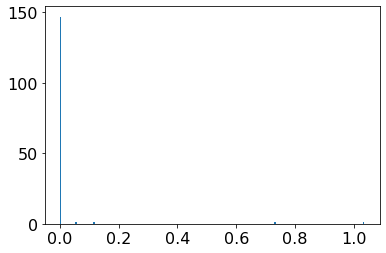

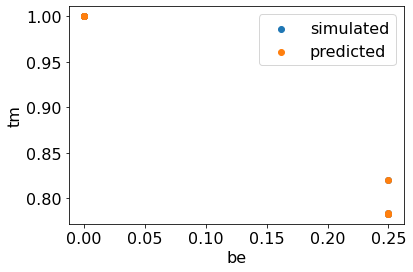

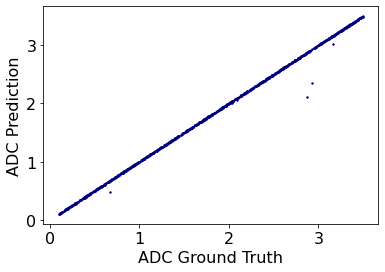

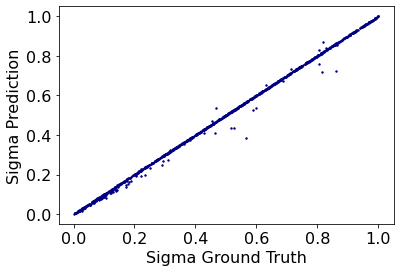

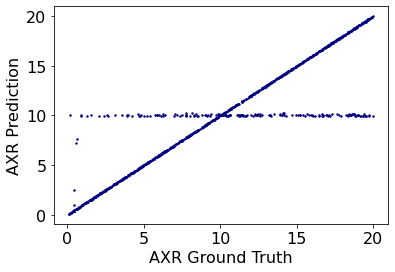

[]


In [224]:
#Debugging sse and seeing how large it is for the worst values. 
sses.sort()
sses_descending = sses[::-1]
sses_bad = sses_descending[sses_descending>sse_threshold]


"""MAYBE ADD LOSS PER 'EPOCH' FOR NLLS
plt.figure()
plt.plot(range(1, len(loss_progress) + 1), loss_progress, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.show()"""


#plotting the sse
plt.figure()
plt.hist(sses_bad.flatten(), bins=200)

plt.figure()
# for first voxel
plt.scatter(be, sim_E_vox[0,:], label='simulated')
plt.scatter(be, NLLS_E_vox_all[0,:], label='predicted')
plt.xlabel("be")
plt.ylabel("tm")
plt.legend()

# plot scatter plots to analyse correlation of predicted free params against ground truth
plt.figure()

param_sim = [sim_adc, sim_sigma, sim_axr]
param_pred = [NLLS_adc_all, NLLS_sigma_all, NLLS_axr_all]
param_name = ['ADC', 'Sigma', 'AXR']

rvals = []

for i,_ in enumerate(param_sim):
    plt.rcParams['font.size'] = '16'
    plt.scatter(param_sim[i], param_pred[i], s=2, c='navy')
    plt.xlabel(param_name[i] + ' Ground Truth')
    plt.ylabel(param_name[i] + ' Prediction')
    #check what line below does. Commented out because it gave an error when using 1 voxel
    #rvals.append(scipy.stats.pearsonr(np.squeeze(param_sim[i]), np.squeeze(param_pred[i])))
    plt.tight_layout
    plt.show()

print(rvals)


### Creating the neural network

In [182]:
class Net(nn.Module): # this is the neural network
    #defining the init and foward pass functions. 

    def __init__(self,be,bf,tm,nparams,limits):
        super(Net, self).__init__()

        self.be = be
        self.bf = bf
        self.tm = tm
        self.limits = limits

        #defining the layers that we want. 
        # 3 layers with no. of be nodes. 
        self.layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.layers.extend([nn.Linear(len(be), len(be)), nn.PReLU()])
            #https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html
        self.encoder = nn.Sequential(*self.layers, nn.Linear(len(be), nparams))

    def forward(self, E_vox):

        params = torch.nn.functional.softplus(self.encoder(E_vox))
        #running a forward pass through the network

        #SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive
        #params contains batch_size x nparams outputs, so each row is adc, sigma and axr.

        #unsqueeze adds an additional dimension. 
        #parameter constraints from Elizabeth matlab 

        adc = torch.tile(torch.clamp(params[:, 0].unsqueeze(1), min=limits[0,0], max=limits[0,1]), (1, tm.shape[0]))
        sigma = torch.tile(torch.clamp(params[:, 1].unsqueeze(1), min=limits[1,0], max=limits[1,1]), (1, tm.shape[0]))
        axr = torch.tile(torch.clamp(params[:, 2].unsqueeze(1), min=limits[2,1], max=limits[2,1]), (1, tm.shape[0]))

        E_vox,_ = sim_sig_pytorch(self.bf, self.be, self.tm, adc, sigma, axr, axr.shape[0])
        #axr.shape[0] is either the batch size or nvox

        return E_vox, adc, sigma, axr


### NN continued

In [183]:
# define network
nparams = 3
#because of adc, sigma and axr

#converting numpy arrays to pytorch tensors. 
be = torch.tensor(be)
bf = torch.tensor(bf)
tm = torch.tensor(tm)
batch_size = 128

#initilise network
net = Net(be, bf, tm, nparams,limits)

#create batch queues for data
#// means divide and round down. 
num_batches = len(sim_E_vox) // batch_size

#import the sim_E_vox array into the dataloader
#drop_last ignores the last batch if it is the wrong size. 
#num_workers is about performance. 

trainloader = utils.DataLoader(torch.from_numpy(sim_E_vox.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 0, #was 2 previously
                                drop_last = True)

# loss function and optimizer
#choosing which loss function to use. 
#not sure what the optmizer is
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# best loss
best = 1e16
num_bad_epochs = 0
#can increase patience a lot, speed not an issue.
patience = 10

### Training

In [184]:
# train
loss_progress = np.empty(shape=(0,)) 
for epoch in range(10000): 
    print("-----------------------------------------------------------------")
    print("epoch: {}; bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    #tqdm shows a progress bar. 
    for i, sim_E_vox_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred_E_vox, pred_adc, pred_sigma, pred_axr = net(sim_E_vox_batch)

        sim_E_vox_batch64 = sim_E_vox_batch.to(torch.float64)
        #needed so that loss comparison works

        loss = criterion(pred_E_vox, sim_E_vox_batch64)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print("loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("####################### saving good model #######################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
        loss_progress = np.append(loss_progress, best)
    else:
        num_bad_epochs = num_bad_epochs + 1
        loss_progress = np.append(loss_progress, best)
        if num_bad_epochs == patience:
            print("done, best loss: {}".format(best))
            break
print("done")

net.load_state_dict(final_model)

net.eval()
with torch.no_grad():
    final_pred_E_vox, final_pred_adc_repeated, final_pred_sigma_repeated, final_pred_axr_repeated = net(torch.from_numpy(sim_E_vox.astype(np.float32)))
    # adc sigma and axr will have 8 columns which are all the same

final_pred_adc = final_pred_adc_repeated[:, 0]
final_pred_sigma = final_pred_sigma_repeated [:, 0]
final_pred_axr = final_pred_axr_repeated[:, 0]


-----------------------------------------------------------------
epoch: 0; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 79.27it/s] 


loss: 1.7672908989252198
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 1; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 127.02it/s]


loss: 1.7091524879829776
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 2; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 273.66it/s]


loss: 1.6439870111286037
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 3; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 251.91it/s]


loss: 1.5688308106437236
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 4; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 145.39it/s]


loss: 1.4770603121196064
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 5; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 313.08it/s]


loss: 1.3643286097636547
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 6; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 362.68it/s]


loss: 1.2437729028879476
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 7; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 135.59it/s]


loss: 1.1387773090499174
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 8; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 302.80it/s]


loss: 1.0578336436091018
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 9; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 341.45it/s]


loss: 1.0046572690770594
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 10; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 310.96it/s]


loss: 0.9771825649877837
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 11; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 228.09it/s]


loss: 0.9621440216866998
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 12; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 203.95it/s]


loss: 0.9490521356917111
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 13; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 323.85it/s]


loss: 0.9365493484911804
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 14; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 382.79it/s]


loss: 0.9242322144569444
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 15; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 408.07it/s]


loss: 0.9117999950074703
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 16; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 367.11it/s]


loss: 0.8978512930845246
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 17; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 336.72it/s]


loss: 0.8823700305006615
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 18; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 119.84it/s]


loss: 0.8639884975075105
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 19; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 151.00it/s]


loss: 0.8459993344893625
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 20; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 143.86it/s]


loss: 0.8255341459706041
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 21; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 370.40it/s]


loss: 0.8030173412361157
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 22; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 333.36it/s]


loss: 0.7770245924880337
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 23; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 398.37it/s]


loss: 0.7492019730978028
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 24; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 181.96it/s]


loss: 0.7165061758408887
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 25; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 214.81it/s]


loss: 0.680112840979804
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 26; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 374.20it/s]


loss: 0.6378874195147699
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 27; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 303.13it/s]


loss: 0.5895413964747519
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 28; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 373.33it/s]


loss: 0.5348402348216363
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 29; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 426.87it/s]


loss: 0.47611577097784114
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 30; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 201.64it/s]


loss: 0.41803856884590523
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 31; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 119.16it/s]


loss: 0.3659976616466669
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 32; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 278.60it/s]


loss: 0.3195507009072806
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 33; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 437.83it/s]


loss: 0.27807726050125026
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 34; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 414.00it/s]


loss: 0.23911603524749192
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 35; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 196.43it/s]


loss: 0.20191250033781585
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 36; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 155.17it/s]


loss: 0.1683702929622119
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 37; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 220.29it/s]


loss: 0.14158138076833957
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 38; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 308.73it/s]


loss: 0.12180373175149886
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 39; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 333.79it/s]


loss: 0.10578949741501589
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 40; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 385.41it/s]


loss: 0.09333622973308914
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 41; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 262.72it/s]


loss: 0.08621890694641429
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 42; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 141.88it/s]


loss: 0.08253072364007034
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 43; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 150.92it/s]


loss: 0.08021425337373252
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 44; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 168.50it/s]


loss: 0.07847974693819391
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 45; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 165.13it/s]


loss: 0.07708155202427806
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 46; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 205.57it/s]


loss: 0.07582863794236772
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 47; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 133.09it/s]


loss: 0.07480322202068741
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 48; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 188.92it/s]


loss: 0.07398433728256852
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 49; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 179.02it/s]


loss: 0.07318924405058
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 50; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 279.71it/s]


loss: 0.07256511000142209
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 51; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 208.74it/s]


loss: 0.07198142124936072
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 52; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 308.10it/s]


loss: 0.07147988315385756
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 53; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 269.30it/s]


loss: 0.0709797429313057
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 54; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 338.49it/s]


loss: 0.07062493541987366
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 55; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 375.84it/s]


loss: 0.0702738682896626
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 56; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 438.45it/s]


loss: 0.06994281804602939
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 57; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 292.41it/s]


loss: 0.06966340790680343
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 58; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 245.45it/s]


loss: 0.06939330869838486
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 59; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 246.62it/s]


loss: 0.06918914728435982
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 60; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 245.88it/s]


loss: 0.06893907409478758
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 61; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 277.86it/s]


loss: 0.0688201382277389
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 62; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 282.53it/s]


loss: 0.06869893120035939
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 63; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 249.09it/s]


loss: 0.0686240161313879
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 64; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 383.55it/s]


loss: 0.06847211973066064
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 65; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 247.01it/s]


loss: 0.06837000307621556
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 66; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 223.14it/s]


loss: 0.06826971394042307
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 67; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 306.48it/s]


loss: 0.0681597875535728
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 68; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 303.85it/s]


loss: 0.06812619374288365
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 69; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 329.26it/s]


loss: 0.06806673531514286
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 70; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 180.55it/s]


loss: 0.06797446134523763
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 71; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 172.34it/s]


loss: 0.0679551409003085
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 72; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 314.36it/s]


loss: 0.06783283708902077
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 73; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 346.71it/s]


loss: 0.06783068693384109
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 74; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 438.69it/s]


loss: 0.06777474846527197
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 75; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 436.03it/s]


loss: 0.06769458076130612
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 76; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 422.46it/s]


loss: 0.0676814395875172
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 77; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 328.19it/s]


loss: 0.06767629196163928
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 78; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 419.24it/s]


loss: 0.06758698481209735
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 79; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 414.14it/s]


loss: 0.06756470277791905
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 80; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 330.35it/s]


loss: 0.06753784915471454
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 81; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 99.15it/s] 


loss: 0.06744635205863204
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 82; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 184.10it/s]


loss: 0.06736157718630534
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 83; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 197.51it/s]


loss: 0.06738811537416302
-----------------------------------------------------------------
epoch: 84; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 408.47it/s]


loss: 0.06727846978836274
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 85; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 273.73it/s]


loss: 0.06732158415556189
-----------------------------------------------------------------
epoch: 86; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 400.38it/s]


loss: 0.06723011648491277
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 87; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 401.01it/s]


loss: 0.06717457295726584
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 88; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 411.55it/s]


loss: 0.06718788729998439
-----------------------------------------------------------------
epoch: 89; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 175.56it/s]


loss: 0.06714950321088192
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 90; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 468.15it/s]


loss: 0.06702175538929245
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 91; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 321.70it/s]


loss: 0.06708984362397775
-----------------------------------------------------------------
epoch: 92; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 168.16it/s]


loss: 0.06704698960548625
-----------------------------------------------------------------
epoch: 93; bad epochs: 2


100%|██████████| 78/78 [00:00<00:00, 139.26it/s]


loss: 0.06686725340295706
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 94; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 276.96it/s]


loss: 0.06700329950408984
-----------------------------------------------------------------
epoch: 95; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 148.26it/s]


loss: 0.06691947911154665
-----------------------------------------------------------------
epoch: 96; bad epochs: 2


100%|██████████| 78/78 [00:00<00:00, 426.76it/s]


loss: 0.06689858105364574
-----------------------------------------------------------------
epoch: 97; bad epochs: 3


100%|██████████| 78/78 [00:00<00:00, 226.40it/s]


loss: 0.06680908994256357
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 98; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 311.81it/s]


loss: 0.06672273645469949
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 99; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 472.06it/s]


loss: 0.06676178127428664
-----------------------------------------------------------------
epoch: 100; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 187.22it/s]


loss: 0.06667189496998595
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 101; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 478.36it/s]


loss: 0.06664068870493053
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 102; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 225.33it/s]


loss: 0.06652361116835312
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 103; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 156.69it/s]


loss: 0.06651236029125551
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 104; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 237.37it/s]


loss: 0.06652204174957141
-----------------------------------------------------------------
epoch: 105; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 285.64it/s]


loss: 0.06641770903375734
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 106; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 233.09it/s]


loss: 0.06632634830626022
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 107; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 173.91it/s]


loss: 0.06626758103180407
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 108; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 310.17it/s]


loss: 0.06625325679389087
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 109; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 413.66it/s]


loss: 0.0661759197910396
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 110; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 463.94it/s]


loss: 0.06601765350283102
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 111; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 370.49it/s]


loss: 0.06604433307893981
-----------------------------------------------------------------
epoch: 112; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 419.02it/s]


loss: 0.06589935603909287
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 113; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 425.15it/s]


loss: 0.06585206831727182
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 114; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 398.52it/s]


loss: 0.0658135140863059
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 115; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 431.68it/s]


loss: 0.0657595460526327
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 116; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 422.41it/s]


loss: 0.06551218029674247
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 117; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 467.87it/s]


loss: 0.06553931542847789
-----------------------------------------------------------------
epoch: 118; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 476.02it/s]


loss: 0.06543155267319478
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 119; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 360.49it/s]


loss: 0.06530656477449008
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 120; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 433.02it/s]


loss: 0.0651485173537496
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 121; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 404.09it/s]


loss: 0.06504283365482354
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 122; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 361.60it/s]


loss: 0.06490412126058775
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 123; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 469.91it/s]


loss: 0.06481790204079436
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 124; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 462.27it/s]


loss: 0.06452286543150126
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 125; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 383.28it/s]


loss: 0.0644355782426281
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 126; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 452.86it/s]


loss: 0.06430952435499354
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 127; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 317.24it/s]


loss: 0.06412434048832262
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 128; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 341.70it/s]


loss: 0.06376984426568537
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 129; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 448.80it/s]


loss: 0.06364986908127762
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 130; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 408.35it/s]


loss: 0.06327474516295149
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 131; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 402.16it/s]


loss: 0.06308315151428495
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 132; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 423.99it/s]


loss: 0.06273212518368786
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 133; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 326.62it/s]


loss: 0.06239229686808522
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 134; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 464.80it/s]


loss: 0.061927004273904594
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 135; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 363.49it/s]


loss: 0.0615080449002411
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 136; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 381.78it/s]


loss: 0.06097496015200791
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 137; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 405.61it/s]


loss: 0.060421870689648785
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 138; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 480.65it/s]


loss: 0.059694675249709034
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 139; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 321.68it/s]


loss: 0.05898855148476443
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 140; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 307.33it/s]


loss: 0.058312902706675794
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 141; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 354.35it/s]


loss: 0.05751055541413626
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 142; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 467.10it/s]


loss: 0.056660402188169194
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 143; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 418.45it/s]


loss: 0.05575412319473506
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 144; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 406.15it/s]


loss: 0.054754680408454166
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 145; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 362.20it/s]


loss: 0.053650569829479536
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 146; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 405.89it/s]


loss: 0.05249024501390148
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 147; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 480.49it/s]


loss: 0.05132871333250031
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 148; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 434.56it/s]


loss: 0.05008564071225606
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 149; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 458.84it/s]


loss: 0.04871871250756397
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 150; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 447.79it/s]


loss: 0.04725634634235085
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 151; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 358.14it/s]


loss: 0.04589974258960476
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 152; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 476.29it/s]


loss: 0.04440094173176878
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 153; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 431.20it/s]


loss: 0.042962574141751655
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 154; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 445.45it/s]


loss: 0.04146457508980704
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 155; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 411.41it/s]


loss: 0.040030693179795344
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 156; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 336.48it/s]


loss: 0.03862794030569038
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 157; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 349.33it/s]


loss: 0.03736067535838503
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 158; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 426.40it/s]


loss: 0.036107101504941806
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 159; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 387.28it/s]


loss: 0.034944620476671066
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 160; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 445.98it/s]


loss: 0.03387523071228501
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 161; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 433.72it/s]


loss: 0.032936981604372445
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 162; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 387.50it/s]


loss: 0.03209820500987527
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 163; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 395.51it/s]


loss: 0.03126346219589076
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 164; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 419.36it/s]


loss: 0.030592357598886764
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 165; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 491.01it/s]


loss: 0.029852951966942147
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 166; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 501.57it/s]


loss: 0.029376387264941236
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 167; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 463.76it/s]


loss: 0.028890156611267453
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 168; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 431.28it/s]


loss: 0.028443469620725987
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 169; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 457.44it/s]


loss: 0.027993794017229418
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 170; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 459.15it/s]


loss: 0.027613441594854737
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 171; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 481.42it/s]


loss: 0.027297282866743003
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 172; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 495.97it/s]


loss: 0.027005973645708177
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 173; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 480.33it/s]


loss: 0.02671568846455979
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 174; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 499.64it/s]


loss: 0.0264940195895203
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 175; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 440.54it/s]


loss: 0.02627896521296987
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 176; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 446.70it/s]


loss: 0.02609900574891855
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 177; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 382.14it/s]


loss: 0.025907601033980737
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 178; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 490.05it/s]


loss: 0.02571764978681371
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 179; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 456.04it/s]


loss: 0.025586645150051747
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 180; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 475.80it/s]


loss: 0.025469425745109464
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 181; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 429.03it/s]


loss: 0.025384578084341258
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 182; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 438.97it/s]


loss: 0.025245632967009865
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 183; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 462.05it/s]


loss: 0.02519282895166509
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 184; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 456.44it/s]


loss: 0.02511747338123249
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 185; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 492.14it/s]


loss: 0.025016898689728687
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 186; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 434.14it/s]


loss: 0.02494673596818468
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 187; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 424.69it/s]


loss: 0.02489193472182876
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 188; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 464.48it/s]


loss: 0.024877883569288845
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 189; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 493.34it/s]


loss: 0.024801485090525557
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 190; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 332.17it/s]


loss: 0.02475175162975737
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 191; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 302.49it/s]


loss: 0.024718558459239287
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 192; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 317.09it/s]


loss: 0.02469192083140479
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 193; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 386.38it/s]


loss: 0.024590077799414457
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 194; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 388.34it/s]


loss: 0.02462645047787289
-----------------------------------------------------------------
epoch: 195; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 385.23it/s]


loss: 0.024586504756215873
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 196; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 359.48it/s]


loss: 0.02459316231851246
-----------------------------------------------------------------
epoch: 197; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 417.91it/s]


loss: 0.02455956400619985
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 198; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 373.40it/s]


loss: 0.024451345251188448
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 199; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 414.94it/s]


loss: 0.024505893225362455
-----------------------------------------------------------------
epoch: 200; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 417.89it/s]


loss: 0.024501551792356933
-----------------------------------------------------------------
epoch: 201; bad epochs: 2


100%|██████████| 78/78 [00:00<00:00, 80.14it/s]


loss: 0.024456402336857377
-----------------------------------------------------------------
epoch: 202; bad epochs: 3


100%|██████████| 78/78 [00:01<00:00, 53.87it/s] 


loss: 0.02441659736583793
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 203; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 169.56it/s]


loss: 0.024442472061071863
-----------------------------------------------------------------
epoch: 204; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 150.98it/s]


loss: 0.02443663350333347
-----------------------------------------------------------------
epoch: 205; bad epochs: 2


100%|██████████| 78/78 [00:00<00:00, 108.22it/s]


loss: 0.024406924383194476
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 206; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 190.39it/s]


loss: 0.024366995466073234
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 207; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 188.16it/s]


loss: 0.02438030968127807
-----------------------------------------------------------------
epoch: 208; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 147.95it/s]


loss: 0.02436388645486277
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 209; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 155.81it/s]


loss: 0.02436023430596944
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 210; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 180.24it/s]


loss: 0.024336418424530326
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 211; bad epochs: 0


100%|██████████| 78/78 [00:01<00:00, 59.39it/s] 


loss: 0.02436303827855699
-----------------------------------------------------------------
epoch: 212; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 101.88it/s]


loss: 0.024310114375217927
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 213; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 118.69it/s]


loss: 0.024296478138680723
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 214; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 121.57it/s]


loss: 0.02430684841484211
-----------------------------------------------------------------
epoch: 215; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 159.56it/s]


loss: 0.02432273753713967
-----------------------------------------------------------------
epoch: 216; bad epochs: 2


100%|██████████| 78/78 [00:00<00:00, 182.84it/s]


loss: 0.02427245157925338
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 217; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 263.49it/s]


loss: 0.024199756675235193
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 218; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 151.82it/s]


loss: 0.024221323953705055
-----------------------------------------------------------------
epoch: 219; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 164.38it/s]


loss: 0.024280156231411037
-----------------------------------------------------------------
epoch: 220; bad epochs: 2


100%|██████████| 78/78 [00:00<00:00, 94.02it/s] 


loss: 0.02427087048846735
-----------------------------------------------------------------
epoch: 221; bad epochs: 3


100%|██████████| 78/78 [00:00<00:00, 143.19it/s]


loss: 0.024252896583670684
-----------------------------------------------------------------
epoch: 222; bad epochs: 4


100%|██████████| 78/78 [00:00<00:00, 118.90it/s]


loss: 0.02424700772141967
-----------------------------------------------------------------
epoch: 223; bad epochs: 5


100%|██████████| 78/78 [00:00<00:00, 190.69it/s]


loss: 0.02423898961888535
-----------------------------------------------------------------
epoch: 224; bad epochs: 6


100%|██████████| 78/78 [00:00<00:00, 90.35it/s]


loss: 0.02419686278552851
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 225; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 118.99it/s]


loss: 0.024235356713328143
-----------------------------------------------------------------
epoch: 226; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 97.64it/s] 


loss: 0.024214002964128185
-----------------------------------------------------------------
epoch: 227; bad epochs: 2


100%|██████████| 78/78 [00:00<00:00, 208.51it/s]


loss: 0.024194743874056786
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 228; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 147.28it/s]


loss: 0.024190126257649845
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 229; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 272.31it/s]


loss: 0.0242110845383997
-----------------------------------------------------------------
epoch: 230; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 102.38it/s]


loss: 0.02408922763013858
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 231; bad epochs: 0


100%|██████████| 78/78 [00:00<00:00, 121.20it/s]


loss: 0.024167865743512543
-----------------------------------------------------------------
epoch: 232; bad epochs: 1


100%|██████████| 78/78 [00:00<00:00, 166.94it/s]


loss: 0.024163867911402362
-----------------------------------------------------------------
epoch: 233; bad epochs: 2


100%|██████████| 78/78 [00:00<00:00, 119.03it/s]


loss: 0.024098536085478076
-----------------------------------------------------------------
epoch: 234; bad epochs: 3


100%|██████████| 78/78 [00:00<00:00, 121.41it/s]


loss: 0.024155017793127363
-----------------------------------------------------------------
epoch: 235; bad epochs: 4


100%|██████████| 78/78 [00:00<00:00, 107.20it/s]


loss: 0.02415455218713854
-----------------------------------------------------------------
epoch: 236; bad epochs: 5


100%|██████████| 78/78 [00:00<00:00, 125.57it/s]


loss: 0.02411930554006525
-----------------------------------------------------------------
epoch: 237; bad epochs: 6


100%|██████████| 78/78 [00:00<00:00, 205.18it/s]


loss: 0.024150224689813826
-----------------------------------------------------------------
epoch: 238; bad epochs: 7


100%|██████████| 78/78 [00:00<00:00, 143.58it/s]


loss: 0.02410204683004119
-----------------------------------------------------------------
epoch: 239; bad epochs: 8


100%|██████████| 78/78 [00:00<00:00, 141.40it/s]


loss: 0.02411991894668697
-----------------------------------------------------------------
epoch: 240; bad epochs: 9


100%|██████████| 78/78 [00:00<00:00, 129.10it/s]

loss: 0.024121949013262988
done, best loss: 0.02408922763013858
done


### NN Plots

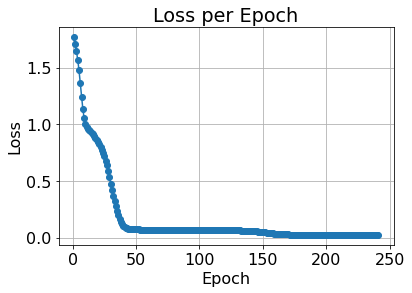

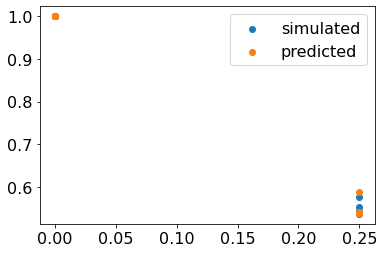

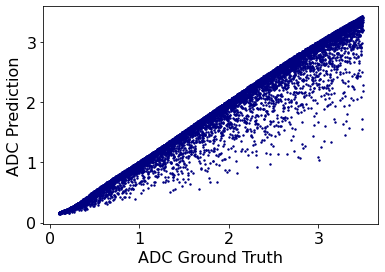

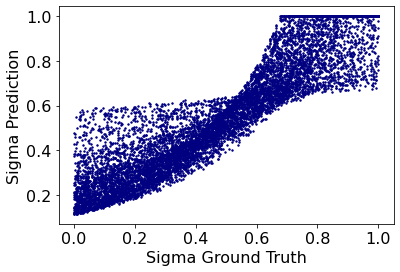

/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


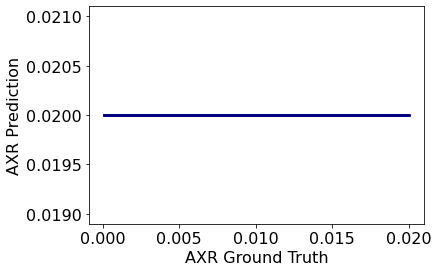

[(0.9783446948589818, 0.0), (0.9294874721220905, 0.0), (nan, nan)]


In [185]:
plt.figure()
plt.plot(range(1, len(loss_progress) + 1), loss_progress, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.show()

final_pred_E_vox_detached = final_pred_E_vox.detach().numpy()
"""Was having numpy pytorch issues, so this line helps fix it a bit."""

plt.scatter(be, sim_E_vox[0,:], label='simulated')
plt.scatter(be, final_pred_E_vox_detached[0,:], label='predicted')
plt.legend()

# plot scatter plots to analyse correlation of predicted free params against ground truth
plt.figure()

param_sim = [sim_adc, sim_sigma, sim_axr]
param_pred = [final_pred_adc, final_pred_sigma, final_pred_axr]
param_name = ['ADC', 'Sigma', 'AXR']

rvals = []

for i,_ in enumerate(param_sim):
    plt.rcParams['font.size'] = '16'
    plt.scatter(param_sim[i], param_pred[i], s=2, c='navy')
    plt.xlabel(param_name[i] + ' Ground Truth')
    plt.ylabel(param_name[i] + ' Prediction')
    rvals.append(scipy.stats.pearsonr(np.squeeze(param_sim[i]), np.squeeze(param_pred[i])))
    plt.tight_layout
    plt.show()

print(rvals)
